In [3]:
import os
import glob
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torchvision
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

In [7]:
train_path = "dataset/train"
test_path = "dataset/test"

In [5]:
def display_images(folder_path, num_images=10):
    
    classes = os.listdir(folder_path)
    image_paths = [glob.glob(f"{os.path.join(folder_path, clas)}/*.jpg") for clas in classes]
    image_paths_full = list(itertools.chain(image_paths[0], image_paths[1]))
    
    selected = random.sample(image_paths_full, num_images)
    
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    
    for i, img_path in enumerate(selected):
        img = Image.open(img_path)
        ax = axs[i // 5, i % 5]
        ax.imshow(img)
        ax.set_title(img_path.split('/')[-2])
        ax.axis('off')
    plt.show()

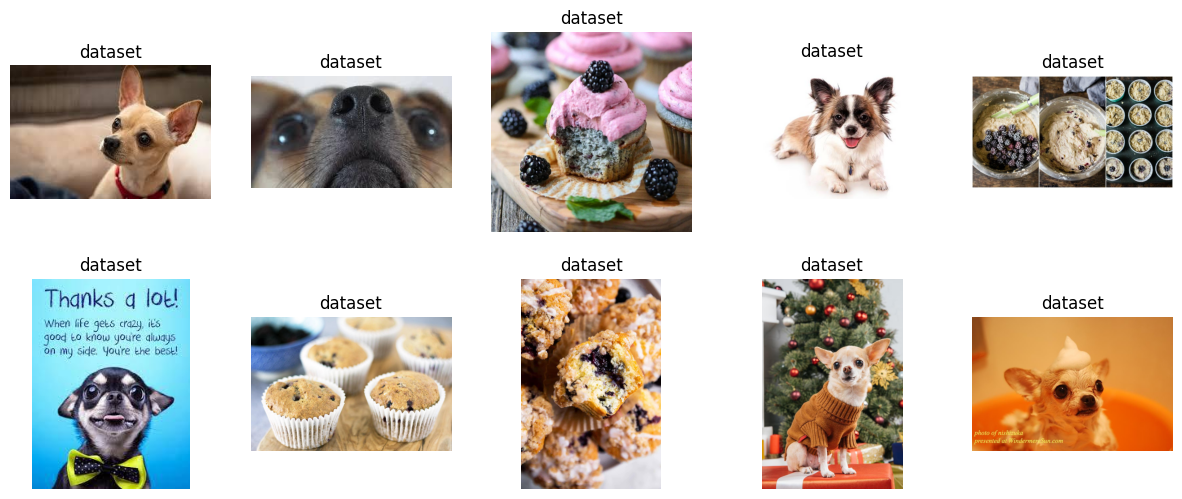

In [9]:
display_images(train_path)

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.1),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
train_ds = torchvision.datasets.ImageFolder(train_path, transform=train_transform)
test_ds = torchvision.datasets.ImageFolder(test_path, transform=test_transform)
train_ds, test_ds

(Dataset ImageFolder
     Number of datapoints: 4733
     Root location: dataset/train
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-0.1, 0.1], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 1184
     Root location: dataset/test
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ))

In [12]:
train_dataloader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=32)

In [13]:
model = models.mobilenet_v3_small(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\korsh624.VIRO/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth
100.0%


In [14]:
for param in model.parameters():
    param.requires_grad = False

In [15]:
model.classifier = nn.Sequential(
    *model.classifier,
    nn.Linear(model.classifier[3].out_features, len(train_ds.classes))
)
model.classifier

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1000, bias=True)
  (4): Linear(in_features=1000, out_features=2, bias=True)
)

In [16]:
for param in model.classifier.parameters():
    param.requires_grad = True

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [18]:
model = model.to(device)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

In [20]:
def train_one_epoch(model, train_dataloader, criterion, optimizer):
    model.train()
    
    total_loss = 0
    for images, labels in tqdm(train_dataloader):
            
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_dataloader)
    return avg_loss


In [21]:
def test(model, test_dataloader, criterion):
    model.eval()
    
    with torch.no_grad():

        total_loss = 0
        correct = 0

        for images, labels in tqdm(test_dataloader):
            
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / len(test_dataloader.dataset)
        avg_loss = total_loss / len(test_dataloader)
        
    return avg_loss, accuracy

In [22]:
def train(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=10):
    
    for epoch in range(num_epochs):
        
        train_loss = train_one_epoch(model, train_dataloader, criterion, optimizer)
        test_loss, accuracy = test(model, test_dataloader, criterion)

        print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Accuracy:{accuracy:.2f}%')

In [23]:
train(model, train_dataloader, test_dataloader, criterion, optimizer, 10)

100%|██████████| 37/37 [00:22<00:00,  1.68it/s]


Epoch: 1/10 | Train Loss: 0.1301 | Test Loss: 0.0318 | Accuracy:98.82%


100%|██████████| 37/37 [00:17<00:00,  2.14it/s]


Epoch: 2/10 | Train Loss: 0.0494 | Test Loss: 0.0356 | Accuracy:98.56%


100%|██████████| 37/37 [00:17<00:00,  2.10it/s]


Epoch: 3/10 | Train Loss: 0.0485 | Test Loss: 0.0336 | Accuracy:98.31%


100%|██████████| 37/37 [00:17<00:00,  2.15it/s]


Epoch: 4/10 | Train Loss: 0.0344 | Test Loss: 0.0264 | Accuracy:98.82%


100%|██████████| 37/37 [00:17<00:00,  2.07it/s]


Epoch: 5/10 | Train Loss: 0.0335 | Test Loss: 0.0241 | Accuracy:98.65%


100%|██████████| 37/37 [00:16<00:00,  2.25it/s]


Epoch: 6/10 | Train Loss: 0.0334 | Test Loss: 0.0391 | Accuracy:98.65%


100%|██████████| 37/37 [00:16<00:00,  2.24it/s]


Epoch: 7/10 | Train Loss: 0.0274 | Test Loss: 0.0222 | Accuracy:98.90%


100%|██████████| 37/37 [00:16<00:00,  2.26it/s]


Epoch: 8/10 | Train Loss: 0.0336 | Test Loss: 0.0214 | Accuracy:99.16%


100%|██████████| 37/37 [00:16<00:00,  2.25it/s]


Epoch: 9/10 | Train Loss: 0.0198 | Test Loss: 0.0225 | Accuracy:98.90%


100%|██████████| 37/37 [00:16<00:00,  2.25it/s]

Epoch: 10/10 | Train Loss: 0.0193 | Test Loss: 0.0213 | Accuracy:98.82%


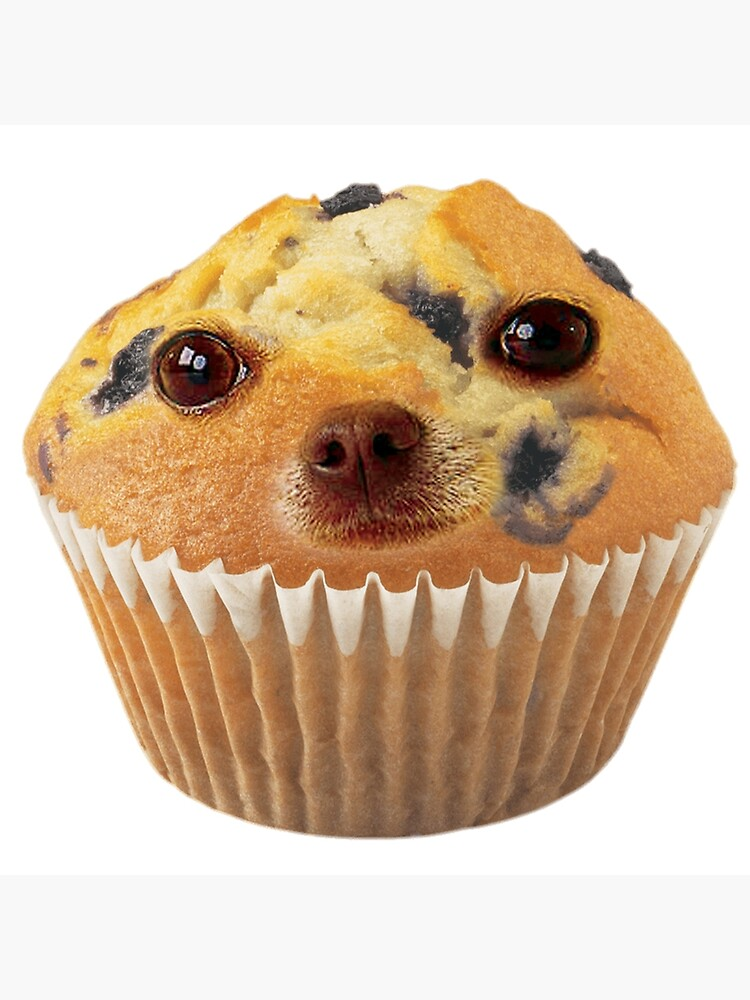

In [26]:
img = Image.open('img.jpg')
img

In [27]:
img = test_transform(img)

In [28]:
output = model(img.unsqueeze(0).to(device))
torch.argmax(output).item() 

1

определил как маффин

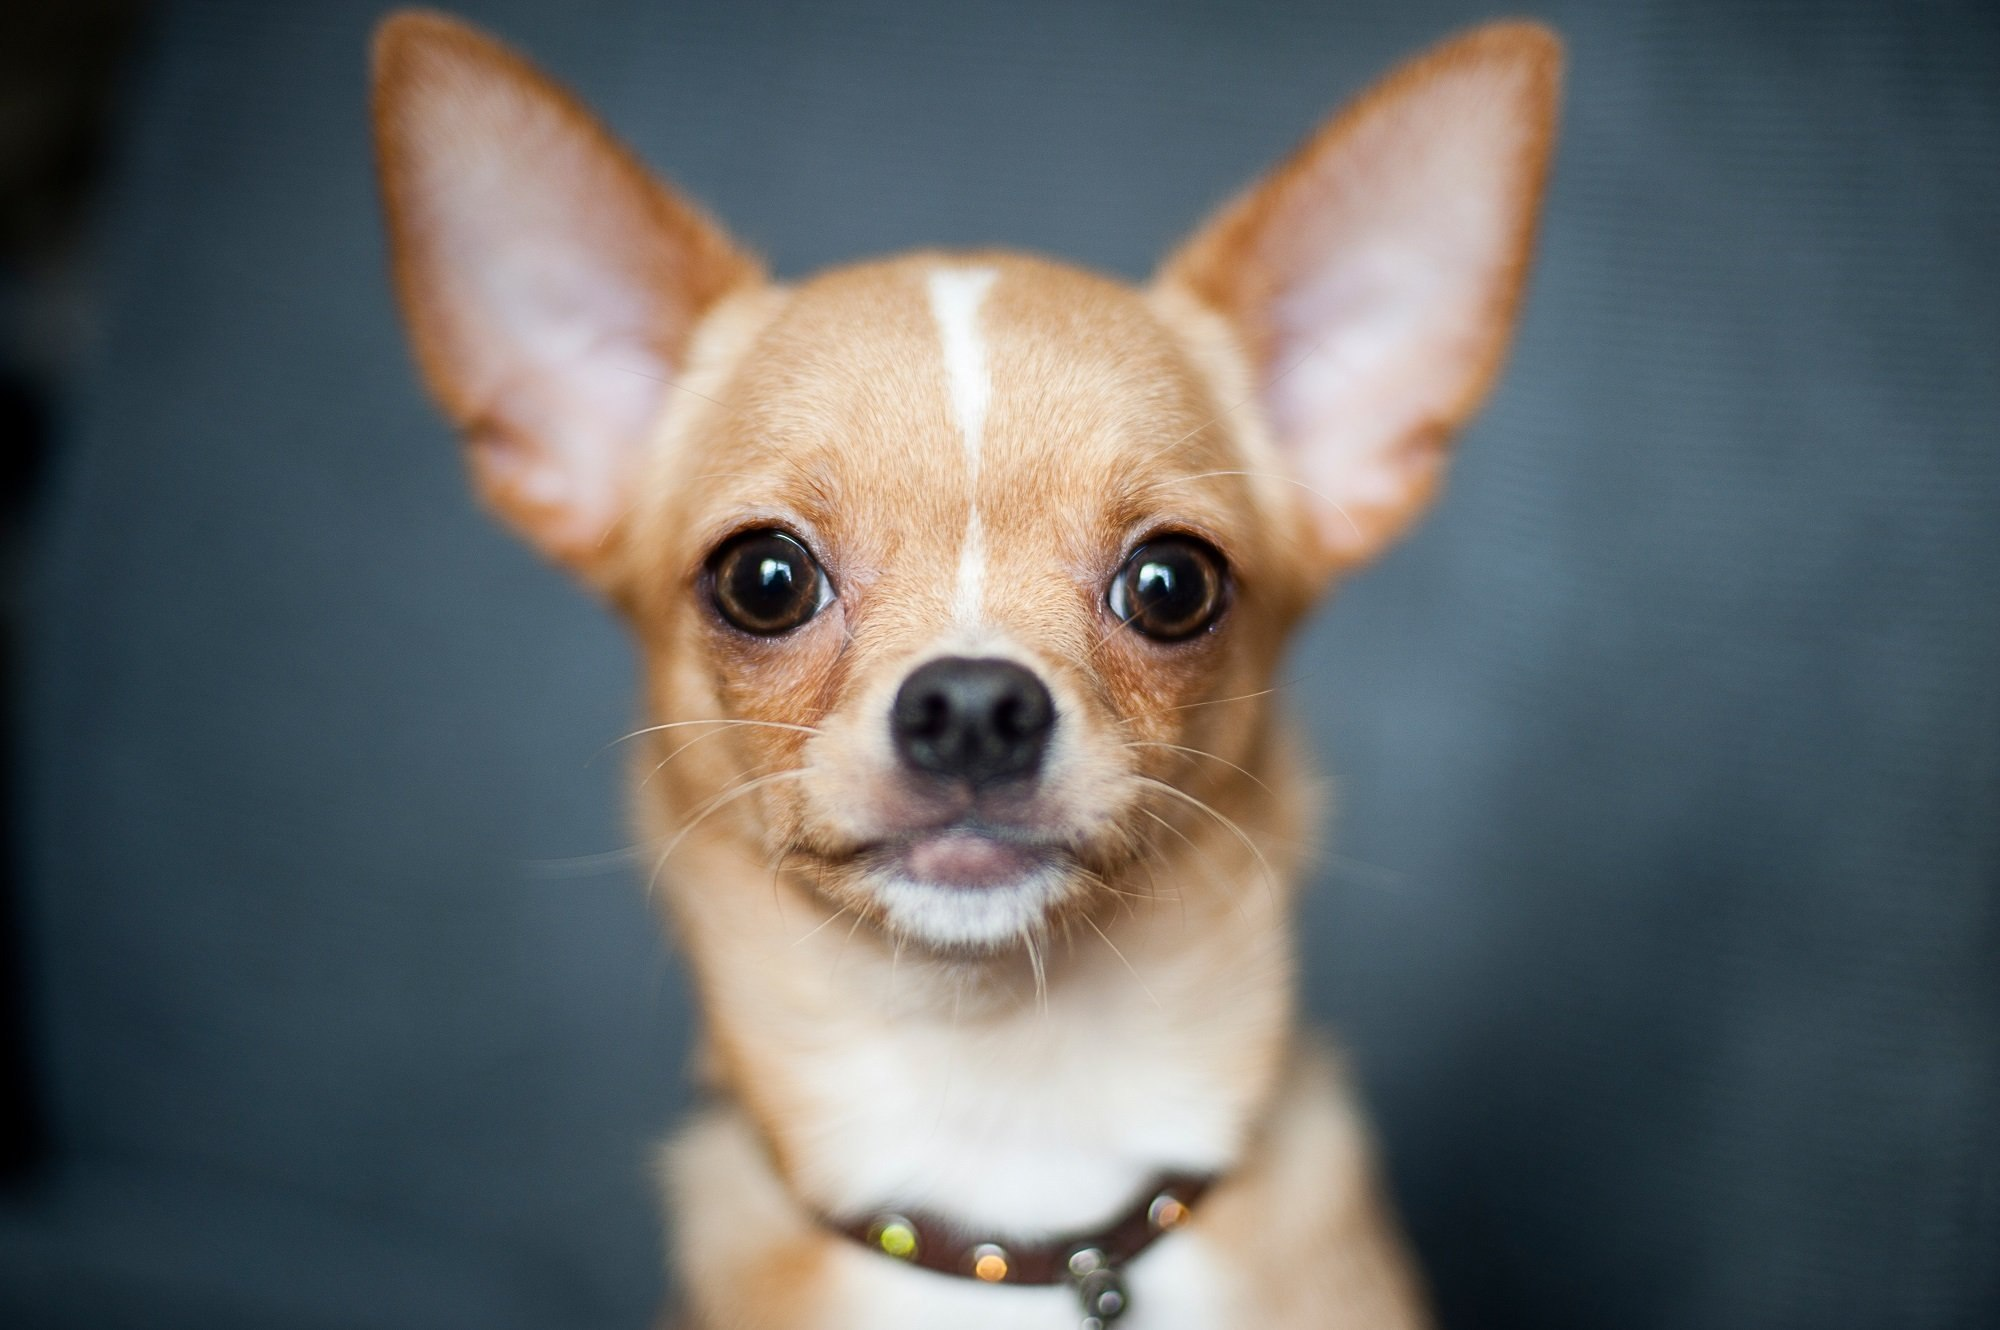

In [29]:
img = Image.open('chihuahua.jpg')
img

In [30]:
img = test_transform(img)

In [31]:
output = model(img.unsqueeze(0).to(device))
torch.argmax(output).item() 

0

Это чихуахуа